In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from time import localtime, strftime

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [300]:
# Number of samples in each class

TEST_SAMPLE_NUMBER = 51745
TRAIN_SAMPLE_NUMBER = 257367

# array1: [sX1; sY1; sX2; sY2; ...]
# array2: [eX1; eY1; eX2; eY2; ...]
# output: [dist((sX1, sY1), (eX1, eY1)), dist((sX1, sY1), (eX1, eY1)),
#          dist((sX2, sY2), (eX2, eY2)), dist((sX2, sY2), (eX2, eY2)), ...]

def distance_for_each_point(array1, array2):
    array_length = len(array1)
    len2 = len(array2)
    assert (array_length == len2), "Arrays' sizes have to be equal (array1: {}, array2: {})".format(array_length, len2)
    
    if array1.ndim == 1:
        distance = np.linalg.norm((array1 - array2).reshape((int(array_length / 2), 2)), axis=1)
        result = np.array([[d, d] for d in distance]).flatten()
    else:
        result = np.array([distance_for_each_point(array1[i], array2[i]) for i in range(array_length)])
    
    return result

# metrics between real results (in tests) and predicted
def distance(test_results, predicted_results):
    return distance_for_each_point(np.array(test_results), predicted_results).sum() / TEST_SAMPLE_NUMBER / 2

# data may be present as [n_features * n_samples] or [n_samples * n_features] 
# usually algorithms require second variant but I prefer first
def to_model(df):
    return np.array(df).T

In [301]:
# you need to pass as arguments function to execute, test_results to compare with predicted by function,
# parameter_name to know results by which parameter you want to compare and list_of_values for this parameter
# also you need to pass other argument which function will use 
# it's always some test_data and usually train_data and train_results

def compare_results(function, test_results, parameter_name, list_of_values, **other_parameters):
    result = [] # we will keep results for each configuration here

    for i, value in enumerate(list_of_values):
        print("{cur}/{num}: {t}".format(cur=i+1, num=len(list_of_values), t=strftime("%Y-%m-%d %H:%M:%S", localtime())))
        other_parameters[parameter_name] = value        
        predicted_results = function(**other_parameters)
        np.save("src/Logs/{date}_predicted_coordinates_{function_name}_{parameter_name}_".format(
                date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name)
                + str(value), predicted_results)
        result.append(distance(test_results, predicted_results))
        
    print("done! {time}".format(time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
    print("Results: {}".format(result))
        
    ind = list_of_values
    number = len(ind)
    width = 2 / number
    result_bar = plt.bar(range(number), result, width, color='g')

    plt.ylabel('Average difference')
    plt.xlabel(parameter_name)
    plt.title("Difference between real points and predicted by {parameter_name} in {function_name}".format(
        function_name=function.__name__, parameter_name=parameter_name))
    plt.xticks(np.array(range(number)) + width/2, ind)
    plt.savefig("src/Plots/{date}_{function_name}_difference_by_{parameter_name}.png".format(
        date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name))    

In [302]:
ZERO_PADDING = 6

def get_filename(index):
    return "src/Csv/{}.txt".format(str(index).zfill(ZERO_PADDING))

def get_framename(index):
    return "src/Frame/{}.jpg".format(str(index).zfill(ZERO_PADDING))

NUMBER_OF_PEDESTRIANS = 12273

def download_pedestrian(index):
    assert(0 <= index < NUMBER_OF_PEDESTRIANS), "pedestrian number should be between 0 and {max}; given number: {id}".format(
        max=NUMBER_OF_PEDESTRIANS-1, id=index)
    filename = get_filename(index)
    data = pd.read_csv(filename, index_col=0)
    return data

In [303]:
def find_by_path(path, search_in_test=True):
    
    indeces = np.arange(NUMBER_OF_PEDESTRIANS)
    if search_in_test:
        pedestrian_separation = pd.read_csv('src/pedestrian_labels_and_test_and_train_separation.csv', index_col=0)
        indeces = np.where(np.array(pedestrian_separation['category']) == 'test')[0]
        
    path = path.flatten()    
    len2 = len(path)
        
    for i in indeces:
        df = download_pedestrian(i)
        data = np.array(df).flatten()
        len1 = len(data)
        data_view = np.lib.stride_tricks.as_strided(data, shape=(len1 - len2 + 1, len2),
                                                    strides=(data.dtype.itemsize,) * 2)[::2, :]
        
        ind = np.where(np.all(data_view == path, axis=1))[0]
        if len(ind) > 0:
            return (i, df.index.values[ind[0]])

In [304]:
def make_view(data, length, only_odd_rows=True):
    data = np.array(data).flatten()
    len1 = len(data)
    len2 = length
    return np.lib.stride_tricks.as_strided(data, shape=(len1 - len2 + 1, len2),
                                                    strides=(data.dtype.itemsize,) * 2)[::2 if only_odd_rows else 1, :]

In [297]:
def draw_lines(frame_number, paths, colors, image_name, draw_line=True):
    im = Image.open(get_framename(frame_number))
    draw = ImageDraw.Draw(im)
    for path, color in zip(paths, colors):
        if draw_line:
            path_view = make_view(path, 4)
            for line in path_view:
                draw.line(tuple(line), width=4, fill=color)
        else:
            for point in path:
                draw.ellipse(tuple(np.append(point, point+10)), fill=color)

    im.save("src/Images/{name}.jpg".format(name=image_name))

In [305]:
# reading data from .csv files

test_data = pd.read_csv('src/test_data_points.csv', index_col=0)
train_data = pd.read_csv('src/train_data_points.csv', index_col=0)

# split ten frames in input and output data (we want to predict output by input)

test_results = test_data[5:10]
test_data = test_data[:5]

train_results = train_data[5:10]
train_data = train_data[:5]

In [307]:
from sklearn.neighbors import KNeighborsRegressor

# n_neighbors by defalt is 5;         to compare: range(5, 55, 5)
# weights     by defalt is 'uniform'; to compare: ['uniform', 'distance']
# algorithm   by defalt is 'auto';    to compare: ['auto', 'ball_tree', 'kd_tree', 'brute']
# note: 'brute' is causing some memory error

def kneighbors_regressor(train_data, train_results, test_data, **kwargs):
    neigh = KNeighborsRegressor(**kwargs)
    neigh.fit(to_model(train_data), to_model(train_results))
    return (neigh.predict(to_model(test_data))).T

There is no difference which algorithm to use: ball_tree or kd_tree but kd_tree works faster. Also between 'uniform' and 'distance' (parameter weights) there is no difference neither.
The optimal n_neighbors is 20.

Note: I deleted some cells with comparison. You could find them in previous versions of this notebook on github.

1/7: 2016-10-17 15:26:55
2/7: 2016-10-17 15:27:07
3/7: 2016-10-17 15:27:20
4/7: 2016-10-17 15:27:35
5/7: 2016-10-17 15:27:50
6/7: 2016-10-17 15:28:05
7/7: 2016-10-17 15:28:21
done! 2016-10-17 15:28:37
Results: [113.17510673975144, 108.87199000064523, 107.84029387209145, 107.59976829474584, 107.6816907993154, 107.80930973659719, 107.98541703734323]


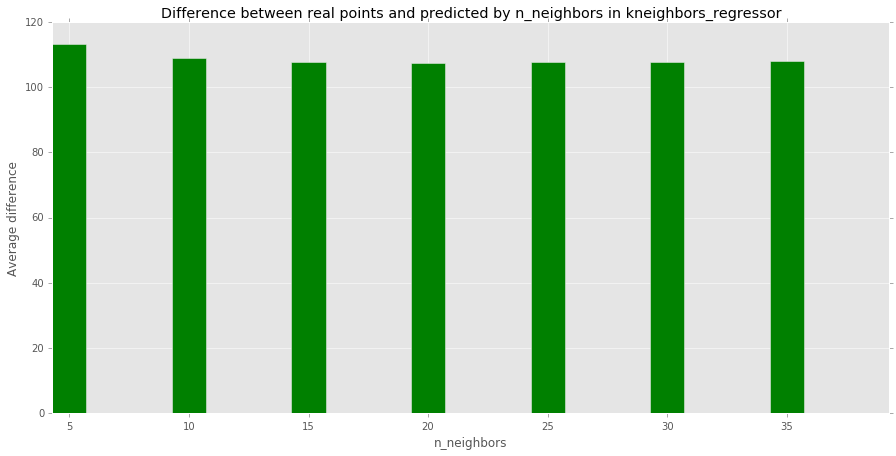

In [308]:
compare_results(function=kneighbors_regressor, test_results=test_results, parameter_name='n_neighbors',
                list_of_values=range(5,40,5), train_data=train_data, train_results=train_results, test_data=test_data)

In [309]:
predicted = np.load('src/Logs/20161017_predicted_coordinates_kneighbors_regressor_n_neighbors_20.npy')
original = np.array(test_results)
dist = distance_for_each_point(predicted, original)

In [310]:
sum_dist = dist.sum(axis=0) 
indeces = sum_dist.argsort()

In [311]:
sum_dist[indeces[-2:]]

array([ 2292.67178617,  2292.67178617])

In [312]:
original_path = original[:, indeces[-2:]]
original_path

array([[1706,  949],
       [1678,  979],
       [1648, 1006],
       [1629, 1038],
       [1592, 1069]], dtype=int64)

In [313]:
predicted_path = predicted[:, indeces[-2:]]
predicted_path

array([[ 1658.35,   626.25],
       [ 1620.7 ,   587.6 ],
       [ 1582.05,   553.3 ],
       [ 1542.3 ,   518.55],
       [ 1506.  ,   488.6 ]])

In [314]:
pedestrian, first_frame = find_by_path(original_path)

In [315]:
pedestrian

4499

In [316]:
first_frame

51300

In [317]:
df = download_pedestrian(pedestrian)

In [319]:
prev_path = np.array(df.loc[range(first_frame - 5 * 20, first_frame, 20)])

In [320]:
prev_path

array([[1821,  843],
       [1816,  856],
       [1786,  875],
       [1754,  891],
       [1680,  415]], dtype=int64)

In [323]:
draw_lines(frame_number=first_frame, paths=[prev_path, original_path, predicted_path], colors=['blue', 'green', 'red'],
           image_name='ped4499', draw_line=False)